In [1]:
import numpy as np
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf

In [2]:
logMh_m = 11.5
logMh_M = 14.72
logMh_bin = 0.02
logMh_N = int((logMh_M - logMh_m) / logMh_bin)

In [3]:
halos = np.load('main_halo_zspace.npy')

In [3]:
particle = np.loadtxt('./dm_xyz_snap_010_thin.dat')

In [19]:
import pickle
with open('halo_particle_pair_count_fwhm6_pimax140.bin', 'rb') as f:
    count = pickle.load(f)

In [31]:
# bins = np.arange(logMh_N+1) * logMh_bin + logMh_m
# res = np.digitize(np.log10(halos['M_h']), bins)
# NDs = np.bincount(res, minlength=logMh_N+1)
# NDs = NDs[1:]
# np.save('halo_mass_function.npy', np.rec.fromarrays([(bins[1:]+bins[:-1])/2, NDs], dtype=[('Mass', float), ('count', int)]))

calculate the wp

In [20]:
vol = np.pi*(count[0]['rmax']**2 - count[0]['rmin']**2)*1           # delta r pi = 1

In [21]:
boxsize = 2500
NR = 1000_000_000
n = NR / (boxsize**3)
RR = count[0].copy()
RR['npairs'] = (NR*vol*n*2).astype('uint64')            # this has been cross checked to be correct

In [22]:
NDs = np.load('halo_mass_function.npy')['count']

In [23]:
pimax = 140
Nbins = len(RR['npairs'])//pimax

In [24]:
w_ps = []
ND2 = particle.shape[0]
D2R1 = RR.copy()
D2R1['npairs'] = ND2*vol*n*2
R1R2 = RR
for i in range(logMh_N):
    if count[i] is None:
        w_ps.append(np.zeros_like(w_ps[0]))
        continue
    D1D2 = count[i]
    ND1 = NDs[i]
    D1R2 = RR.copy()
    D1R2['npairs'] = ND1*vol*n*2
    
    w_ps.append(convert_rp_pi_counts_to_wp(ND1, ND2, NR, NR, D1D2, D1R2, D2R1, R1R2, pimax=pimax, nrpbins=Nbins))

In [25]:
wp_array = np.vstack(w_ps)

In [26]:
np.save(f'cm_wp', wp_array)

Check the result

In [29]:
import matplotlib.pyplot as plt

In [31]:
wp_arrays = [np.load(f'cm_{pimax}.npy') for pimax in [80, 140, 200]]

In [32]:
sep_min = 0.1
sep_max = 100
sep_N = 30
r_pbins = np.geomspace(sep_min, sep_max, sep_N+1)
r_p = (r_pbins[1:]*r_pbins[:-1])**0.5

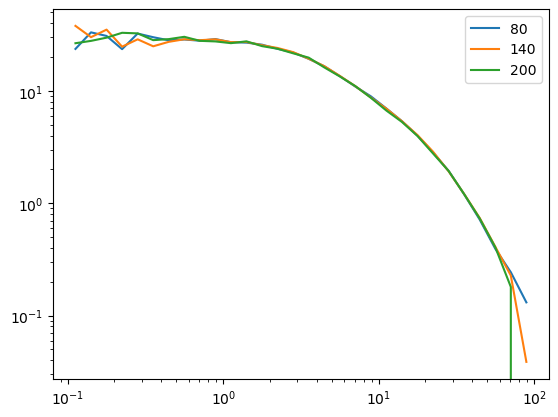

In [33]:
for i in range(3):
    plt.plot(r_p, wp_arrays[i][75]['wp'], label=str([80, 140, 200][i]))
plt.loglog()
plt.legend()

cross check the DR and RR

In [58]:
boxsize = 2500
X = np.random.uniform(0, boxsize, 1_000_000_0)
Y = np.random.uniform(0, boxsize, 1_000_000_0)
Z = np.random.uniform(0, boxsize, 1_000_000_0)

In [59]:
from Corrfunc.theory import DD, DDrppi
sep_min = 0.1
sep_max = 100
sep_N = 30

pimax = 140
boxsize = 2500

r_pbins = np.geomspace(sep_min, sep_max, sep_N+1)

NR = 1000_000_0
n = NR / (boxsize**3)

In [60]:
DR_real = DDrppi(0, 40, pimax, r_pbins, X1=X, Y1=Y, Z1=Z, X2=particle[:,0].T, Y2=particle[:,1].T, Z2=particle[:,2].T, periodic=True, boxsize=boxsize, verbose=True)
D1R2 = RR.copy()
D1R2['npairs'] = particle.shape[0]*vol*n*2
D1R2['npairs'] / DR_real['npairs']

array([1.01992337, 1.03579767, 1.0175841 , ..., 0.99999798, 0.99995332,
       1.00003926])